# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [1]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile

# Memory
import gc

# Processing
import bisect
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [2]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [3]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [4]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

_id   GISJOIN  \
8466   {'$oid': '615fc624bf06594c4cad628a'}  G0800250   
18982  {'$oid': '615fc626bf06594c4cad8cb1'}  G0800590   
24763  {'$oid': '615fc626bf06594c4cada353'}  G0800770   
32407  {'$oid': '615fc627bf06594c4cadc2d7'}  G0801010   
35170  {'$oid': '615fc628bf06594c4cadcdf8'}  G0801110   

                             epoch_time dateString     county     state  \
8466   {'$numberLong': '1590127200000'}    5/22/20    Crowley  Colorado   
18982  {'$numberLong': '1605769200000'}   11/19/20  Jefferson  Colorado   
24763  {'$numberLong': '1621144800000'}    5/16/21       Mesa  Colorado   
32407  {'$numberLong': '1617256800000'}     4/1/21     Pueblo  Colorado   
35170  {'$numberLong': '1593928800000'}     7/5/20   San Juan  Colorado   

       totalCaseCount  newCaseCount  totalDeathCount  newDeathCount  
8466               44             1                1              0  
18982           16299           582              404             11  
24763           15064            28              218              0  
32407           15876            46              365              1  
35170               2             0                0              0

In [5]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

name              label
2  totalDeathCount  Total Death Count
3     newCaseCount     New Case Count
4   totalCaseCount   Total Case Count
1    newDeathCount    New Death Count
0       epoch_time               Date

In [6]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

_id     type  \
41  {'$oid': '604964eefed2e95d6b68b841'}  Feature   
6   {'$oid': '604964eefed2e95d6b68b844'}  Feature   
62  {'$oid': '604964eefed2e95d6b68b9c3'}  Feature   
33  {'$oid': '604964ecfed2e95d6b68b67b'}  Feature   
8   {'$oid': '604964eefed2e95d6b68b846'}  Feature   

                                             geometry  \
41  {'type': 'Polygon', 'coordinates': [[[-107.918...   
6   {'type': 'MultiPolygon', 'coordinates': [[[[-1...   
62  {'type': 'MultiPolygon', 'coordinates': [[[[-1...   
33  {'type': 'Polygon', 'coordinates': [[[-106.206...   
8   {'type': 'Polygon', 'coordinates': [[[-106.191...   

                                           properties   GISJOIN  
41  {'STATEFP10': '08', 'COUNTYFP10': '081', 'COUN...  G0800810  
6   {'STATEFP10': '08', 'COUNTYFP10': '013', 'COUN...  G0800130  
62  {'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...  G0801230  
33  {'STATEFP10': '08', 'COUNTYFP10': '065', 'COUN...  G0800650  
8   {'STATEFP10': '08', 'COUNTYFP10': '015', 'COUN...  G0800150

#### NEON 2D Wind Dataset

In [7]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

_id                        site  \
7601     {'$oid': '60cbc55451c1683b46b1b8fc'}  ARIK_DP1.00001.001_200.000   
933934   {'$oid': '60cbc28251c1683b4662f54b'}  RMNP_DP1.00001.001_000.030   
1192053  {'$oid': '60cbc05051c1683b4625fb42'}  STER_DP1.00001.001_000.010   
661078   {'$oid': '60cbc6f451c1683b46deccc4'}  NIWO_DP1.00001.001_000.030   
352825   {'$oid': '60cbc07e51c1683b462b00ba'}  CPER_DP1.00001.001_000.020   

                               epoch_time         startDateTime  \
7601     {'$numberLong': '1477294200000'}  2016-10-24T07:30:00Z   
933934   {'$numberLong': '1490504400000'}  2017-03-26T05:00:00Z   
1192053  {'$numberLong': '1550602800000'}  2019-02-19T19:00:00Z   
661078   {'$numberLong': '1555727400000'}  2019-04-20T02:30:00Z   
352825   {'$numberLong': '1534795200000'}  2018-08-20T20:00:00Z   

                  endDateTime  windSpeedMean  windSpeedMinimum  \
7601     2016-10-24T08:00:00Z           1.07              0.41   
933934   2017-03-26T05:30:00Z           0.65              0.02   
1192053  2019-02-19T19:30:00Z           3.74              2.03   
661078   2019-04-20T03:00:00Z           1.79              0.03   
352825   2018-08-20T20:30:00Z           4.01              1.20   

         windSpeedMaximum  windSpeedVariance  windSpeedNumPts  \
7601                 2.16               0.15             1800   
933934               1.86               0.08             1800   
1192053              6.86               0.54             1800   
661078               6.81               2.82             1800   
352825               7.60               1.18             1800   

         windSpeedExpUncert  windSpeedStdErMean  windSpeedFinalQF  \
7601                   0.04                0.01                 0   
933934                 0.04                0.01                 0   
1192053                0.20                0.02                 0   
661078                 0.20                0.04                 0   
352825                 0.24                0.03                 0   

         windDirMean  windDirVariance  windDirNumPts  windDirExpUncert  \
7601           69.17           650.61           1800              0.07   
933934        332.26           884.41           1800              0.07   
1192053       130.04            62.00           1800              0.19   
661078        312.59          6103.16           1800              0.07   
352825        145.81           352.02           1800              0.07   

         windDirStdErMean  windDirFinalQF  
7601                 0.03               0  
933934               0.05               1  
1192053              0.00               1  
661078               0.04               1  
352825               0.01               1

In [8]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

name  \
43             windDirNullNAQM   
57               windDirBetaQM   
22  windSpeedSensorErrorFailQM   
26     windSpeedValidCalPassQM   
27       windSpeedValidCalNAQM   

                                                label  
43  Wind direction quality metric that summarizes ...  
57  Wind direction quality metric detailing the ou...  
22  Wind speed quality metric that summarizes the ...  
26  Wind speed quality metric that summarizes the ...  
27  Wind speed quality metric that summarizes when...

In [9]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

_id     type  \
11  {'$oid': '60cbcf5eed5577c25c20520a'}  Feature   
1   {'$oid': '60cbcf5eed5577c25c205233'}  Feature   
10  {'$oid': '60cbcf5eed5577c25c20520b'}  Feature   
5   {'$oid': '60cbcf5eed5577c25c205294'}  Feature   
0   {'$oid': '60cbcf5eed5577c25c205230'}  Feature   

                                             geometry  \
11  {'type': 'Point', 'coordinates': [-103.02929, ...   
1   {'type': 'Point', 'coordinates': [-105.545955,...   
10  {'type': 'Point', 'coordinates': [-104.74559, ...   
5   {'type': 'Point', 'coordinates': [-105.58238, ...   
0   {'type': 'Point', 'coordinates': [-105.545955,...   

                                           properties  \
11  {'HOR.VER': '000.030', 'name': 'CFGLOC100115',...   
1   {'HOR.VER': '000.040', 'name': 'CFGLOC100675',...   
10  {'HOR.VER': '000.010', 'name': 'CFGLOC100239',...   
5   {'HOR.VER': '000.010', 'name': 'CFGLOC109345',...   
0   {'HOR.VER': '000.010', 'name': 'CFGLOC100666',...   

                          site  
11  STER_DP1.00001.001_000.030  
1   RMNP_DP1.00001.001_000.040  
10  CPER_DP1.00001.001_000.010  
5   NIWO_DP1.00001.001_000.010  
0   RMNP_DP1.00001.001_000.010

#### NEON Barometric Pressure Dataset

In [10]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

_id                site  \
14221   {'$oid': '60c78aabc8cb4f3f3be1a28d'}  ARIK_DP1.00004.001   
104360  {'$oid': '60c78b06c8cb4f3f3bec350c'}  COMO_DP1.00004.001   
470412  {'$oid': '60c78ce3c8cb4f3f3b231ffa'}  STER_DP1.00004.001   
69388   {'$oid': '60c78ab2c8cb4f3f3be27986'}  ARIK_DP1.00004.001   
396094  {'$oid': '60c78cdac8cb4f3f3b21fe65'}  STER_DP1.00004.001   

                              epoch_time         startDateTime  \
14221   {'$numberLong': '1516813200000'}  2018-01-24T17:00:00Z   
104360  {'$numberLong': '1559334600000'}  2019-05-31T20:30:00Z   
470412  {'$numberLong': '1588192200000'}  2020-04-29T20:30:00Z   
69388   {'$numberLong': '1621137600000'}  2021-05-16T04:00:00Z   
396094  {'$numberLong': '1452596400000'}  2016-01-12T11:00:00Z   

                 endDateTime  staPresMean  staPresMinimum  staPresMaximum  \
14221   2018-01-24T17:30:00Z     88.73909        88.71702        88.75714   
104360  2019-05-31T21:00:00Z     70.87427        70.85937        70.87938   
470412  2020-04-29T21:00:00Z     86.81118        86.78817        86.82818   
69388   2021-05-16T04:30:00Z     88.01267        87.97256        88.03256   
396094  2016-01-12T11:30:00Z     86.41394        86.40356        86.42356   

        staPresVariance  staPresNumPts  staPresExpUncert  staPresStdErMean  \
14221           0.00015            180           0.01729           0.00090   
104360          0.00003            180           0.01722           0.00040   
470412          0.00010            180           0.01806           0.00076   
69388           0.00032            180           0.04736           0.00133   
396094          0.00004            180           0.01722           0.00044   

        staPresFinalQF    corPres  corPresExpUncert  corPresFinalQF  
14221                0  102.68780           0.08694               0  
104360               0  100.62311           0.47339               0  
470412               0  101.42068           0.10248               0  
69388                0  101.12874           0.10316               0  
396094               0  102.96140           0.12306               0

In [11]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

name                                              label
27      staPresSpikeNAQM  Station pressure quality metric that summarize...
34  staPresFinalQFSciRvw  Station pressure quality flag indicating wheth...
25    staPresSpikeFailQM  Station pressure quality metric that summarize...
22      staPresGapFailQM  Station pressure quality metric that summarize...
19     staPresNullFailQM  Station pressure quality metric that summarize...

In [12]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

_id     type  \
1  {'$oid': '60c78a9d230c7f49850c20ef'}  Feature   
3  {'$oid': '60c78a9d230c7f49850c20cf'}  Feature   
6  {'$oid': '60c78a9d230c7f49850c20a5'}  Feature   
0  {'$oid': '60c78a9d230c7f49850c20dc'}  Feature   
5  {'$oid': '60c78a9d230c7f49850c20e3'}  Feature   

                                            geometry  \
1  {'type': 'Point', 'coordinates': [-105.914674,...   
3  {'type': 'Point', 'coordinates': [-105.58238, ...   
6  {'type': 'Point', 'coordinates': [-102.450966,...   
0  {'type': 'Point', 'coordinates': [-105.545955,...   
5  {'type': 'Point', 'coordinates': [-103.02929, ...   

                                          properties                site  
1  {'site': 'WLOU_DP1.00004.001', 'name': 'neon_b...  WLOU_DP1.00004.001  
3  {'site': 'NIWO_DP1.00004.001', 'name': 'neon_b...  NIWO_DP1.00004.001  
6  {'site': 'ARIK_DP1.00004.001', 'name': 'neon_b...  ARIK_DP1.00004.001  
0  {'site': 'RMNP_DP1.00004.001', 'name': 'neon_b...  RMNP_DP1.00004.001  
5  {'site': 'STER_DP1.00004.001', 'name': 'neon_b...  STER_DP1.00004.001

#### NEON Air Temperature

In [13]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

_id                        site  \
788876  {'$oid': '60cbd51c0fc3818c81076e43'}  RMNP_DP1.00002.001_000.030   
992839  {'$oid': '60cbd3a20fc3818c81da4c88'}  STER_DP1.00002.001_000.010   
82175   {'$oid': '60cbd7450fc3818c8148a441'}  ARIK_DP1.00002.001_200.000   
379645  {'$oid': '60cbd3c70fc3818c81deabe2'}  CPER_DP1.00002.001_000.030   
145808  {'$oid': '60cbd81b0fc3818c8161e7e3'}  COMO_DP1.00002.001_200.000   

                              epoch_time         startDateTime  \
788876  {'$numberLong': '1439562600000'}  2015-08-14T14:30:00Z   
992839  {'$numberLong': '1496460600000'}  2017-06-03T03:30:00Z   
82175   {'$numberLong': '1614142800000'}  2021-02-24T05:00:00Z   
379645  {'$numberLong': '1472932800000'}  2016-09-03T20:00:00Z   
145808  {'$numberLong': '1603371600000'}  2020-10-22T13:00:00Z   

                 endDateTime  tempSingleMean  tempSingleMinimum  \
788876  2015-08-14T15:00:00Z         18.8830            17.9384   
992839  2017-06-03T04:00:00Z         13.9876            13.9141   
82175   2021-02-24T05:30:00Z         -1.5326            -1.9357   
379645  2016-09-03T20:30:00Z         27.8156            26.4598   
145808  2020-10-22T13:30:00Z          7.1554             6.9533   

        tempSingleMaximum  tempSingleVariance  tempSingleNumPts  \
788876            19.8700              0.2738              1800   
992839            14.0432              0.0012              1800   
82175             -1.1782              0.0277              1800   
379645            29.4116              0.4996              1800   
145808             7.3519              0.0065              1800   

        tempSingleExpUncert  tempSingleStdErMean  finalQF  
788876               0.1449               0.0123        1  
992839               0.1403               0.0008        0  
82175                0.1365               0.0039        0  
379645               0.1505               0.0167        0  
145808               0.1399               0.0019        0

In [14]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

name                                              label
8   tempSingleExpUncert  Expanded uncertainty for single aspirated air ...
9   tempSingleStdErMean  Standard error of the mean for single aspirate...
36         validCalNAQM  Quality metric that summarizes when the valid ...
30             flowNAQM  Quality metric that summarizes when the flow r...
35       validCalPassQM  Quality metric that summarizes the passed outc...

In [15]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

_id     type  \
4   {'$oid': '60cbd3907adbc5ff35cc424e'}  Feature   
14  {'$oid': '60cbd3907adbc5ff35cc41a2'}  Feature   
5   {'$oid': '60cbd3907adbc5ff35cc421b'}  Feature   
0   {'$oid': '60cbd3907adbc5ff35cc41cb'}  Feature   
12  {'$oid': '60cbd3907adbc5ff35cc41a1'}  Feature   

                                             geometry  \
4   {'type': 'Point', 'coordinates': [-105.914674,...   
14  {'type': 'Point', 'coordinates': [-103.02929, ...   
5   {'type': 'Point', 'coordinates': [-105.544602,...   
0   {'type': 'Point', 'coordinates': [-105.545955,...   
12  {'type': 'Point', 'coordinates': [-103.02929, ...   

                                           properties  \
4   {'HOR.VER': '200.000', 'name': 'CFGLOC104136',...   
14  {'HOR.VER': '000.020', 'name': 'CFGLOC100017',...   
5   {'HOR.VER': '200.000', 'name': 'CFGLOC101559',...   
0   {'HOR.VER': '000.030', 'name': 'CFGLOC100671',...   
12  {'HOR.VER': '000.010', 'name': 'CFGLOC100016',...   

                          site  
4   WLOU_DP1.00002.001_200.000  
14  STER_DP1.00002.001_000.020  
5   COMO_DP1.00002.001_200.000  
0   RMNP_DP1.00002.001_000.030  
12  STER_DP1.00002.001_000.010

### U.S. Census Total County Population Dataset

In [16]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

_id   GISJOIN     STATE  STATEFP  \
0   {'$oid': '607d4c2708e81eceb6b6e384'}  G0800010  Colorado        8   
1   {'$oid': '607d4c2708e81eceb6b6e385'}  G0800030  Colorado        8   
2   {'$oid': '607d4c2708e81eceb6b6e386'}  G0800050  Colorado        8   
3   {'$oid': '607d4c2708e81eceb6b6e387'}  G0800070  Colorado        8   
4   {'$oid': '607d4c2708e81eceb6b6e388'}  G0800090  Colorado        8   
..                                   ...       ...       ...      ...   
58  {'$oid': '607d4c2708e81eceb6b6e3bf'}  G0801170  Colorado        8   
59  {'$oid': '607d4c2708e81eceb6b6e3c4'}  G0801190  Colorado        8   
60  {'$oid': '607d4c2708e81eceb6b6e3c3'}  G0801210  Colorado        8   
61  {'$oid': '607d4c2708e81eceb6b6e3c2'}  G0801230  Colorado        8   
62  {'$oid': '607d4c2708e81eceb6b6e3c5'}  G0801250  Colorado        8   

    STATENH             COUNTY  COUNTYFP  COUNTYNH  1980_total_population  \
0        80       Adams County         1        10                 245944   
1        80     Alamosa County         3        30                  11799   
2        80    Arapahoe County         5        50                 293621   
3        80   Archuleta County         7        70                   3664   
4        80        Baca County         9        90                   5419   
..      ...                ...       ...       ...                    ...   
58       80      Summit County       117      1170                   8848   
59       80      Teller County       119      1190                   8034   
60       80  Washington County       121      1210                   5304   
61       80        Weld County       123      1230                 123438   
62       80        Yuma County       125      1250                   9682   

    1990_total_population  2000_total_population  2010_total_population  
0                  265038                 363857                 441603  
1                   13617                  14966                  15445  
2                  391511                 487967                 572003  
3                    5345                   9898                  12084  
4                    4556                   4517                   3788  
..                    ...                    ...                    ...  
58                  12881                  23548                  27994  
59                  12468                  20555                  23350  
60                   4812                   4926                   4814  
61                 131821                 180936                 252825  
62                   8954                   9841                  10043  

[63 rows x 12 columns]

In [17]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

Empty DataFrame
Columns: []
Index: []

In [18]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

_id     type  \
0   {'$oid': '604964ecfed2e95d6b68b676'}  Feature   
1   {'$oid': '604964ecfed2e95d6b68b684'}  Feature   
2   {'$oid': '604964eefed2e95d6b68bb16'}  Feature   
3   {'$oid': '604964eefed2e95d6b68b9c8'}  Feature   
4   {'$oid': '604964eefed2e95d6b68b83d'}  Feature   
..                                   ...      ...   
59  {'$oid': '604964ecfed2e95d6b68b677'}  Feature   
60  {'$oid': '604964eefed2e95d6b68b840'}  Feature   
61  {'$oid': '604964eefed2e95d6b68b9c5'}  Feature   
62  {'$oid': '604964eefed2e95d6b68b9c3'}  Feature   
63  {'$oid': '604964ecfed2e95d6b68b674'}  Feature   

                                             geometry  \
0   {'type': 'Polygon', 'coordinates': [[[-104.961...   
1   {'type': 'Polygon', 'coordinates': [[[-105.457...   
2   {'type': 'MultiPolygon', 'coordinates': [[[[-1...   
3   {'type': 'Polygon', 'coordinates': [[[-107.128...   
4   {'type': 'Polygon', 'coordinates': [[[-102.747...   
..                                                ...   
59  {'type': 'Polygon', 'coordinates': [[[-105.924...   
60  {'type': 'Polygon', 'coordinates': [[[-105.329...   
61  {'type': 'Polygon', 'coordinates': [[[-102.779...   
62  {'type': 'MultiPolygon', 'coordinates': [[[[-1...   
63  {'type': 'Polygon', 'coordinates': [[[-102.664...   

                                           properties   GISJOIN  
0   {'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...  G0800010  
1   {'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...  G0800030  
2   {'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...  G0800050  
3   {'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...  G0800070  
4   {'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...  G0800090  
..                                                ...       ...  
59  {'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...  G0801170  
60  {'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...  G0801190  
61  {'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...  G0801210  
62  {'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...  G0801230  
63  {'STATEFP10': '08', 'COUNTYFP10': '125', 'COUN...  G0801250  

[64 rows x 5 columns]

## Data Exploration

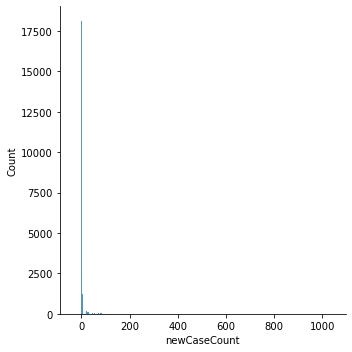

In [19]:
sns.displot(covidDataFrame.newCaseCount)

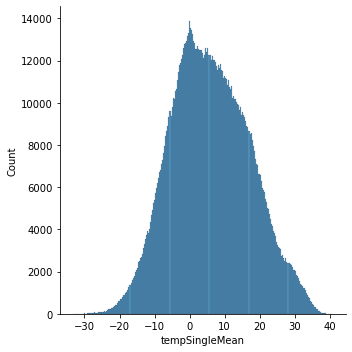

In [20]:
sns.displot(temperatureDataFrame.tempSingleMean)

#### Garbage Collect

In [21]:
del covidDataFrame
del covidLabelsFrame
del covidGeometryFrame

del windDataFrame
del windLabelsFrame
del windGeometryFrame

del pressureDataFrame
del pressureLabelsFrame
del pressureGeometryFrame

del temperatureDataFrame
del temperatureLabelsFrame
del temperatureGeometryFrame

del populationDataFrame
del populationLabelsFrame
del populationGeometryFrame

gc.collect()

69

## Preprocessing

#### Flatten Frames

In [22]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))

flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))

flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Join Data and Geometry

In [23]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

In [24]:
del flattenedCovidDataFrame
del flattenedCovidGeometryFrame

del flattenedWindDataFrame
del flattenedWindGeometryFrame

del flattenedPressureDataFrame
del flattenedPressureGeometryFrame

del flattenedTemperatureDataFrame
del flattenedTemperatureGeometryFrame

del flattenedPopulationDataFrame
del flattenedPopulationGeometryFrame

gc.collect()

20

#### Generalize Geometry

In [25]:
def create_county_polygons(combinedCovidFrame):
    county_polygons = []
    df = combinedCovidFrame.groupby('county').first().reindex(columns=['coordJsonString', 'geometry.type', "geometry.coordinates"])
    print(df)
    df['coordJsonString'] = df["geometry.coordinates"].apply(json.dumps)
    for index, row in df[['coordJsonString', 'geometry.type']].iterrows():
        print(f"processing: {index}")
        shape_data = json.loads(row['coordJsonString'])
        county = index
        if row['geometry.type'] == 'MultiPolygon':
            for p in shape_data:
                s = np.asarray(p)[0]
                shape = Polygon(*s)
                county_polygons.append((county, shape))
        elif row['geometry.type'] == 'Polygon':
            s = np.asarray(shape_data)[0]
            shape = Polygon(*s)
            county_polygons.append((county, shape))
        else:
            print(f"Row had geometry type of {row['geometry.type']}, row is {row}")
    return county_polygons
#
county_polygons = create_county_polygons(combinedCovidFrame)

            coordJsonString geometry.type  \
county                                      
Adams                   NaN       Polygon   
Alamosa                 NaN       Polygon   
Arapahoe                NaN  MultiPolygon   
Archuleta               NaN       Polygon   
Baca                    NaN       Polygon   
...                     ...           ...   
Summit                  NaN       Polygon   
Teller                  NaN       Polygon   
Washington              NaN       Polygon   
Weld                    NaN  MultiPolygon   
Yuma                    NaN       Polygon   

                                         geometry.coordinates  
county                                                         
Adams       [[[-104.96140800028297, 40.00033699940714], [-...  
Alamosa     [[[-105.45725500006058, 37.75146400032936], [-...  
Arapahoe    [[[[-104.93042900099888, 39.66755700030373], [...  
Archuleta   [[[-107.1286799987523, 37.42294200083849], [-1...  
Baca        [[[-102.7476149999

In [26]:
# For O(1) retrieval operation time complexity
polygonCountyMap = {}
countyPolygonMap = {}
countyAvailabilityMap ={}

# For O(log n) search operation time complexity
xSortedCountyPolygons = []
ySortedCountyPolygons = []
countyAvailabilityList = []

for entry in county_polygons:
    county = entry[0]
    polygon = entry[1]
    
    polygonCountyMap[polygon] = county
    countyPolygonMap[county] = polygon
    
    if not county in countyAvailabilityMap:
        countyAvailabilityList.append(county)
    countyAvailabilityMap[county] = True
    
    xSortedCountyPolygons.append((county, countyPolygonMap[county].centroid))
    ySortedCountyPolygons.append((county, countyPolygonMap[county].centroid))
    
xSortedCountyPolygons.sort(key=lambda x:x[1][0])
ySortedCountyPolygons.sort(key=lambda x:x[1][1])

print(county_polygons[0][0])
print(polygonCountyMap[county_polygons[0][1]])

print()
for entry in xSortedCountyPolygons:
    print(N(entry[1][0], 5))
    
print()
for entry in ySortedCountyPolygons:
    print(N(entry[1][1], 5))

Adams
Adams

-108.60
-108.52
-108.47
-108.41
-108.27
-108.22
-108.21
-107.90
-107.86
-107.84
-107.77
-107.68
-107.30
-107.05
-107.03
-106.99
-106.92
-106.92
-106.70
-106.38
-106.34
-106.34
-106.28
-106.19
-106.19
-106.12
-106.12
-105.79
-105.72
-105.64
-105.52
-105.46
-105.44
-105.43
-105.37
-105.36
-105.25
-105.16
-105.10
-105.06
-105.06
-105.05
-105.05
-104.98
-104.96
-104.94
-104.93
-104.93
-104.93
-104.92
-104.91
-104.90
-104.88
-104.53
-104.51
-104.39
-104.34
-104.34
-104.14
-104.04
-103.81
-103.78
-103.72
-103.51
-103.20
-103.11
-103.07
-102.74
-102.60
-102.60
-102.56
-102.42
-102.39
-102.36
-102.35

37.194
37.201
37.278
37.287
37.316
37.319
37.338
37.573
37.583
37.669
37.685
37.752
37.764
37.821
37.903
37.955
37.955
38.004
38.081
38.109
38.156
38.173
38.327
38.402
38.433
38.473
38.667
38.747
38.828
38.832
38.861
38.882
38.988
39.018
39.119
39.202
39.217
39.287
39.305
39.330
39.586
39.599
39.626
39.628
39.634
39.635
39.650
39.667
39.671
39.681
39.685
39.689
39.699
39.704
39.761
3

In [27]:
def append_counties_to_frame(frame):
    frame['county'] = np.nan
    for index, row in frame.iterrows():
        point = Point(np.asarray(row['geometry.coordinates']))

        availabilityMap = countyAvailabilityMap.copy()
        availabilityList = countyAvailabilityList.copy()

        xKeys = [N(r[1][0]) for r in xSortedCountyPolygons]
        yKeys = [N(r[1][1]) for r in ySortedCountyPolygons]

        xIndex = bisect.bisect_left(xKeys, N(point[0]))
        yIndex = bisect.bisect_left(yKeys, N(point[1]))

        axisToggle = True
        xLeftRightToggle = True
        yLeftRightToggle = True
        currentLeftX = xIndex
        currentRightX = xIndex
        currentYLeft = yIndex
        currentYRight = yIndex
        attempts = 1
        while availabilityList:
            # Toggle heuristic search between X and Y axis
            if axisToggle:
                test = None
                if xLeftRightToggle:
                    test = xSortedCountyPolygons[currentRightX]
                else:
                    test = xSortedCountyPolygons[currentLeftX]

                county = test[0]
                centroid = test[1]

                if availabilityMap[county]:
                    shape = countyPolygonMap[county]

                    # Check if county shape includes this location
                    if shape.encloses_point(point):
                        frame.at[index, 'county'] = county
                        print('County: ' + county)
                        break

                    attempts = attempts + 1
                    availabilityMap[county] = False
                    availabilityList.remove(county)

                if xLeftRightToggle:
                    currentRightX = currentRightX + 1
                    if currentRightX >= len(xSortedCountyPolygons):
                        currentRightX = 0
                    xLeftRightToggle = False
                else:
                    currentLeftX = currentLeftX - 1
                    if currentLeftX < 0:
                        currentLeftX = len(xSortedCountyPolygons) - 1
                    xLeftRightToggle = True
                    
                toggle = False
            else:
                test = None
                if xLeftRightToggle:
                    test = ySortedCountyPolygons[currentRightY]
                else:
                    test = ySortedCountyPolygons[currentLeftY]
                    
                county = test[0]
                centroid = test[1]

                if availabilityMap[county]:
                    shape = countyPolygonMap[county]

                    # Check if county shape includes this location
                    if shape.encloses_point(point):
                        frame.at[index, 'county'] = county
                        print('County: ' + county)
                        break

                    attempts = attempts + 1
                    availabilityMap[county] = False
                    availabilityList.remove(county)

                if yLeftRightToggle:
                    currentRightY = currentRightY + 1
                    if currentRightY >= len(ySortedCountyPolygons):
                        currentRightY = 0
                    yLeftRightToggle = False
                else:
                    currentLeftY = currentLeftY - 1
                    if currentLeftY < 0:
                        currentLeftY = len(ySortedCountyPolygons) - 1
                    yLeftRightToggle = True
                    
                toggle = True

        print('Attempts: ' + str(attempts))
        print()

In [28]:
append_counties_to_frame(combinedWindFrame)
append_counties_to_frame(combinedPressureFrame)
append_counties_to_frame(combinedTemperatureFrame)

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma
Attempts: 1

County: Yuma

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Boulder
Attempts: 10

County: Bo

KeyboardInterrupt: 

In [ ]:
combinedCovidFrame.to_csv('../data/combined_covid_frame.csv')
combinedWindFrame.to_csv('../data/combined_wind_frame.csv')
combinedPressureFrame.to_csv('../data/combined_pressure_frame.csv')
combinedTemperatureFrame.to_csv('../data/combined_temperature_frame.csv')
combinedPopulationFrame.to_csv('../data/combined_population_frame.csv')

In [ ]:
combinedWindFrame

In [ ]:
combinedPressureFrame

In [ ]:
combinedTemperatureFrame

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20